# ASEL Accident Data Analysis

## Introduction

This report presents an analysis of ASEL accident reports available from the National Transportation Safety Board (NTSB). The purpose of the report is to identify the leading causes of accidents and provide recommendations to the pilot community on how to improve safety. The analysis is based on data available from 2015 up to January 2025.

## Methods

The data used in this analysis includes glider accident reports available from the NTSB's CAROL Query tool, and information on the number of gliders built for each make and mode, collected independently. The accident reports were analyzed using various data analysis and Natural Language Processing (NLP) techniques. The analysis involved the following steps:

1. **Data Loading and Preprocessing**: The data was loaded from JSON and CSV files and preprocessed to clean and format it for analysis.
2. **Exploratory Data Analysis**: The preprocessed data was explored to understand the distribution of accidents by injury severity, make and model of gliders, and accident rates.
3. **Time Series Analysis**: The data was analyzed to understand the trend of accidents over time.
4. **Text Preprocessing**: The narrative text in the accident reports was preprocessed by removing punctuation and special characters, converting all text to lower case, tokenizing the text into individual words, removing stop words, and lemmatizing the words to their root form.
5. **Topic Modeling**: The preprocessed text was used to perform Topic Modeling using [Non-negative Matrix Factorization (NMF)](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) and [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to identify the common themes or issues in the accident narratives.

# Data Import and Preprocessing

The data is imported from a JSON file and preprocessed using a function to flatten nested dictionaries. The 'cm_probableCause' column, which contains the probable causes of the accidents, is preprocessed using Natural Language Processing (NLP) techniques.

## All libraries

In [1]:
import pandas as pd
import numpy as np
import json
import re
import textwrap
from textwrap import wrap
import string
from fuzzywuzzy import fuzz, process
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

/Users/alejandroleda/Documents/projects/ASEL_Safety_Analysis/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alejandroleda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alejandroleda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alejandroleda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Function definitions

In [2]:
def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

# Define function for text preprocessing
def preprocess_text(text):
    # Check if input is a string
    if not isinstance(text, str):
        return ''
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Define function for text preprocessing that outputs lists of words
def preprocess_text_list(text):
    # Check if input is a string
    if not isinstance(text, str):
        return []
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return words

# Define a function to match the make and model names using fuzzy matching
def fuzzy_join(df1, df2, key1, key2, threshold=90, limit=1):
    s = df2[key2].tolist()

    m = df1[key1].apply(lambda x: process.extract(x, s, limit=limit))
    df1['matches'] = m

    m2 = df1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df1['matches'] = m2

    return df1

In [3]:
# Load the JSON file
with open('data/cases2025-01-08_02-18.json', 'r') as f:
    data = json.load(f)

# Flatten the JSON data
flattened_data = [flatten_json(d) for d in data]

# Convert to a pandas DataFrame
df = pd.DataFrame(flattened_data)
df

,cm_mkey,airportId,airportName,cm_closed,cm_completionStatus,cm_hasSafetyRec,cm_highestInjury,cm_isStudy,cm_mode,cm_ntsbNum,...,cm_vehicles_0_cm_findings_18_cm_findingNum,cm_vehicles_0_cm_findings_18_cm_findingCode,cm_vehicles_0_cm_findings_18_cm_findingReportText,cm_vehicles_0_cm_findings_18_cm_findingText,cm_vehicles_0_cm_findings_18_cm_inPc,cm_vehicles_0_cm_findings_19_cm_findingNum,cm_vehicles_0_cm_findings_19_cm_findingCode,cm_vehicles_0_cm_findings_19_cm_findingReportText,cm_vehicles_0_cm_findings_19_cm_findingText,cm_vehicles_0_cm_findings_19_cm_inPc
0,199488,KBAZ,None,False,In work,False,Minor,False,Aviation,CEN25LA065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,199489,6GA4,SPRING VALLEY FARM,False,In work,False,Serious,False,Aviation,ERA25LA085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,199467,None,None,False,In work,False,None,False,Aviation,ANC25LA012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,199455,PVF,PLACERVILLE,False,In work,False,None,False,Aviation,WPR25LA066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,199452,N12,Lakewood,False,In work,False,Minor,False,Aviation,ERA25LA081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,90564,2O3,ANGWIN-PARRETT FIELD,True,Completed,False,None,False,Aviation,WPR15CA076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9232,90566,SEZ,SEDONA,True,Completed,False,None,False,Aviation,WPR15CA078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9233,90565,None,None,True,Completed,False,None,False,Aviation,WPR15LA077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9234,90560,SBP,SAN LUIS COUNTY RGNL,True,Completed,False,None,False,Aviation,WPR15CA074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
for col in df.columns:
    print(col)

cm_mkey
airportId
airportName
cm_closed
cm_completionStatus
cm_hasSafetyRec
cm_highestInjury
cm_isStudy
cm_mode
cm_ntsbNum
cm_originalPublishedDate
cm_vehicles_0_cm_vehicleNum
cm_vehicles_0_DamageLevel
cm_vehicles_0_ExplosionType
cm_vehicles_0_FireType
cm_vehicles_0_cm_injuries_0_cm_hasonBoardInjuryMatrix
cm_vehicles_0_cm_injuries_0_cm_crew_Fatal
cm_vehicles_0_cm_injuries_0_cm_crew_Minor
cm_vehicles_0_cm_injuries_0_cm_crew_None
cm_vehicles_0_cm_injuries_0_cm_crew_Serious
cm_vehicles_0_cm_injuries_0_cm_passengers_Fatal
cm_vehicles_0_cm_injuries_0_cm_passengers_Minor
cm_vehicles_0_cm_injuries_0_cm_passengers_None
cm_vehicles_0_cm_injuries_0_cm_passengers_Serious
cm_vehicles_0_SerialNumber
cm_vehicles_0_aircraftCategory
cm_vehicles_0_amateurBuilt
cm_vehicles_0_make
cm_vehicles_0_model
cm_vehicles_0_numberOfEngines
cm_vehicles_0_registrationNumber
cm_vehicles_0_gaFlight
cm_vehicles_0_cm_events_0_cm_eventNum
cm_vehicles_0_cm_events_0_cicttEventSOEGroup
cm_vehicles_0_cm_events_0_cicttPhaseSO

In [5]:
df['cm_highestInjury'].loc[df['cm_highestInjury'] != 'None'].dropna().value_counts()

cm_highestInjury
Fatal      1476
Minor      1439
Serious     970
Name: count, dtype: int64

In [6]:
df['cm_highestInjury'].loc[df['cm_highestInjury'] != 'None'].dropna().value_counts().sum()

3885

In [7]:
# Render date as string
df['dateString'] = pd.to_datetime(df.cm_eventDate)
df['dateString'] = df['dateString'].dt.strftime('%Y-%m-%d')

In [8]:
df[[
    'cm_Latitude',
    'cm_Longitude', 
    'cm_highestInjury', 
    'dateString', 
    'cm_vehicles_0_make', 
    'cm_vehicles_0_model', 
    'cm_probableCause'
    ]].loc[df['cm_highestInjury'] != 'None'].to_json('data/accident_map.json', orient='records')

In [28]:
df.to_csv('data/accident_data.csv', index=False)

# Geographic distribution of accidents

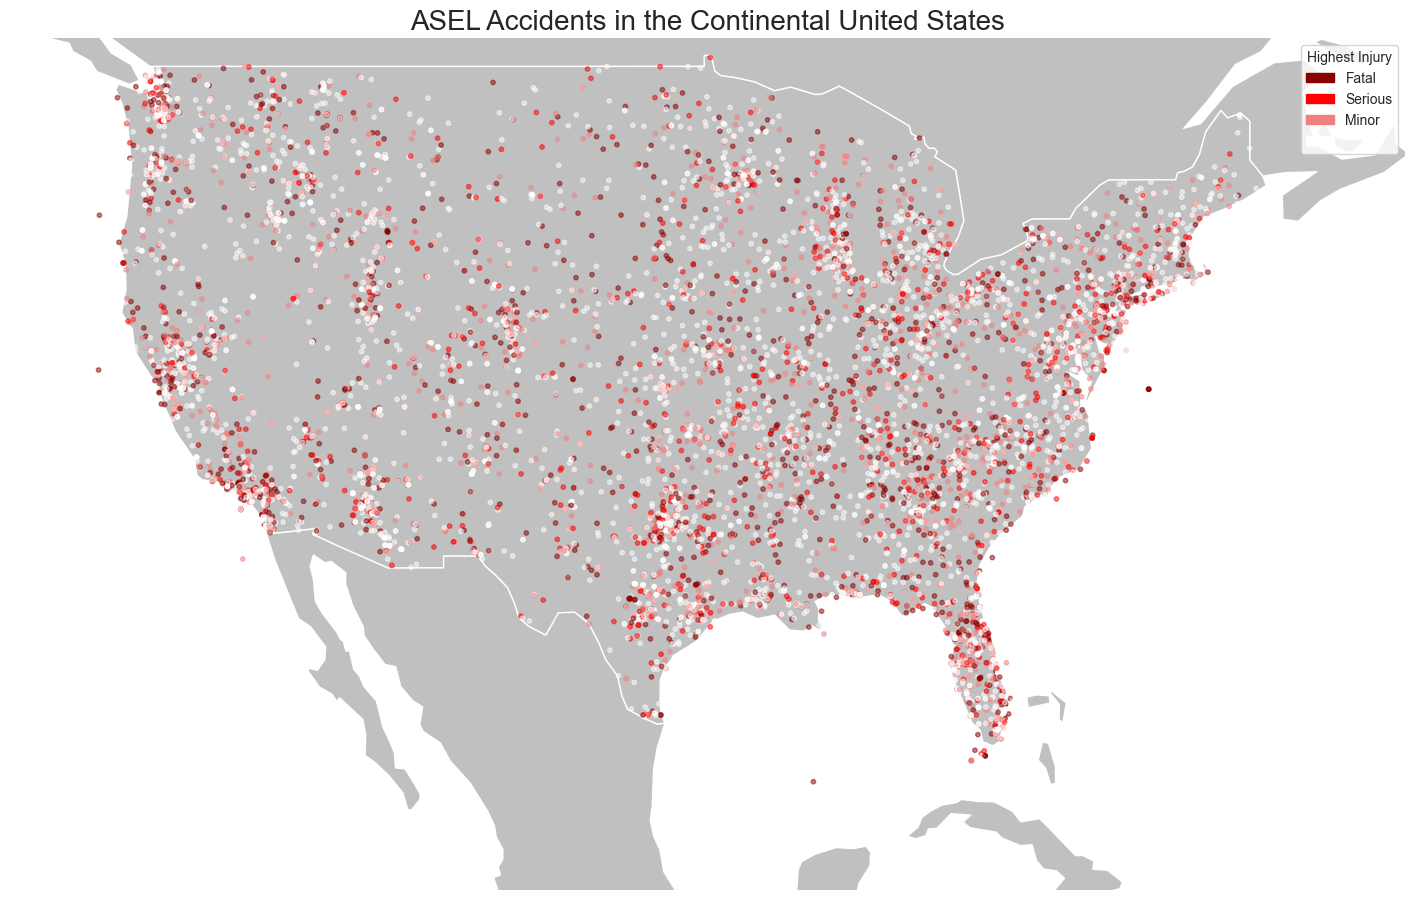

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df['geometry'] = gpd.points_from_xy(df.cm_Longitude, df.cm_Latitude)
geo_df = gpd.GeoDataFrame(df, geometry='geometry')

# Restrict the map to the 48 states of the continental United States
ax = world[world.continent == 'North America'].plot(color='silver', edgecolor='white')
ax.set_xlim(-130, -60)
ax.set_ylim(20, 50)

# Make the map larger
fig = plt.gcf()
fig.set_size_inches(18, 18)

# Filter out the points that are not in the continental United States
geo_df = geo_df[geo_df.cm_Latitude < 50]
geo_df = geo_df[geo_df.cm_Latitude > 20]
geo_df = geo_df[geo_df.cm_Longitude < -60]
geo_df = geo_df[geo_df.cm_Longitude > -130]

# Define color mapping
color_mapping = {'Fatal': 'darkred', 'Serious': 'red', 'Minor': 'lightcoral', 'None': 'white', None: 'white'}
colors = geo_df.cm_highestInjury.map(color_mapping)

# Add the points to the map using scatter plot for better legend handling
scatter = ax.scatter(geo_df.geometry.x, geo_df.geometry.y, c=colors, s=10, alpha=0.5)

# Create a legend
legend_labels = {v: mpatches.Patch(color=v, label=k) for k, v in color_mapping.items()}
plt.legend(handles=legend_labels.values(), title='Highest Injury')

# Add a title
plt.title('ASEL Accidents in the Continental United States', fontsize=20)

# Remove the axis
plt.axis('off')

# Show the map
plt.show()


# NTSB's findings
Findings cited in the Report Text

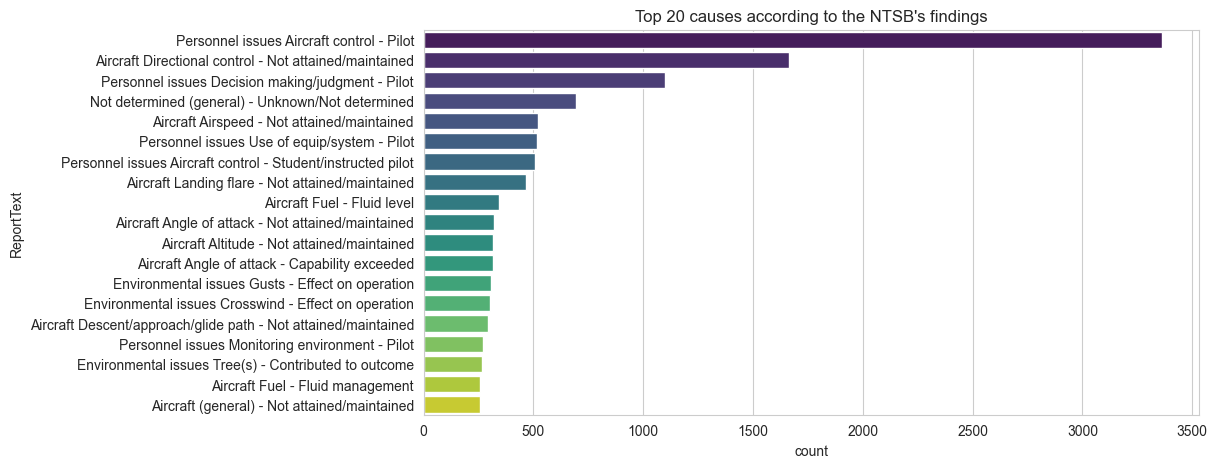

In [11]:
# Provide the value counts for each value in columns with 30 or less unique values
value_counts = {}

for column in df.columns:
  if 'ReportText' in column:
      value_counts[column] = df[column].value_counts().to_dict()

# Concatenate the first level of the value_counts nested dictionary and sum the values for each distinct key on the second level
summed_values = {}

for column, counts in value_counts.items():
    for key, value in counts.items():
        if key in summed_values:
            summed_values[key] += value
        else:
            summed_values[key] = value

summed_values = pd.DataFrame.from_dict(summed_values,  orient="index", columns=['count'])
summed_values.index.name = "ReportText"
summed_values = summed_values.sort_values(by='count', ascending=False)

# Display the top 20 causes cited by the NTSB's findings
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='ReportText', data=summed_values.reset_index().iloc[0:19], palette='viridis')
plt.title("Top 20 causes according to the NTSB's findings")
plt.show()

In [12]:
summed_values.reset_index().iloc[0:30].to_json('data/accident_causes.json', orient='records')

## Phases of flight

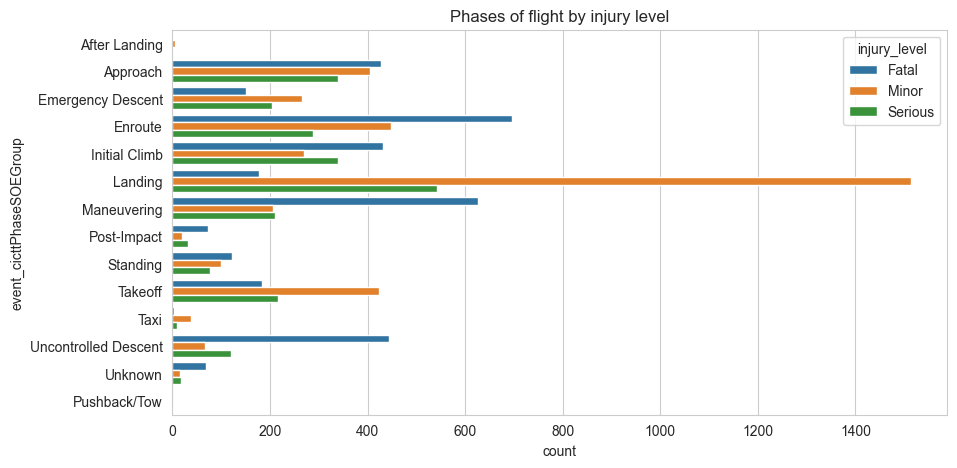

In [13]:
# List to store the extracted vehicles and events
extracted_data = []

# Iterate through the data
for entry in data:
  if (entry['cm_highestInjury'] == 'None'):
    continue
  for key in entry.keys():
    # Check if 'vehicles' key exists
    if 'vehicles' in key:
        # Iterate through the vehicles
        for vehicle in entry[key]:
            # Check if 'events' key exists in vehicle
            for vehicle_key in vehicle.keys():
              if 'events' in vehicle_key:
                  # Iterate through the events
                  for event in vehicle[vehicle_key]:
                    extracted_data.append({
                        'vehicle': vehicle,
                        'event': event,
                        'injury_level': entry['cm_highestInjury'],
                    })

# Flatten the JSON data
flattened_data = [flatten_json(d) for d in extracted_data]

# Convert to a pandas DataFrame
df_events = pd.DataFrame(flattened_data)
phases = pd.DataFrame(df_events['event_cicttPhaseSOEGroup'].value_counts())
phases.index.name = 'phases'

grouped_phases = df_events.groupby(['injury_level', 'event_cicttPhaseSOEGroup']).size().reset_index(name='count')

# Create a bar plot of the grouped phases
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='event_cicttPhaseSOEGroup', hue='injury_level', data=grouped_phases)
plt.title('Phases of flight by injury level')
plt.show()


In [14]:
grouped_phases.reset_index().to_json('data/accident_phases.json', orient='records')

In [15]:
# Event labels
# List to store the extracted vehicles and events
extracted_data = []

# Iterate through the data
for entry in data:
  if (entry['cm_highestInjury'] == 'None') or (entry['cm_highestInjury'] == 'Minor'):
    continue
  for key in entry.keys():
    # Check if 'vehicles' key exists
    if 'vehicles' in key:
        # Iterate through the vehicles
        for vehicle in entry[key]:
            # Check if 'events' key exists in vehicle
            for vehicle_key in vehicle.keys():
              if 'events' in vehicle_key:
                  # Iterate through the events
                  for event in vehicle[vehicle_key]:
                    extracted_data.append({
                        'vehicle': vehicle,
                        'event': event,
                        'injury_level': entry['cm_highestInjury']
                    })

# Flatten the JSON data
flattened_data = [flatten_json(d) for d in extracted_data]

# Convert to a pandas DataFrame
df_events = pd.DataFrame(flattened_data)
df_events_grouped = df_events.groupby(['injury_level', 'event_cicttEventSOEGroup']).size().reset_index(name='count')

df_events_grouped = df_events_grouped.loc[df_events_grouped['event_cicttEventSOEGroup'] != 'Other']
df_events_grouped.sort_values(by=['injury_level', 'count'], ascending=False, inplace=True)

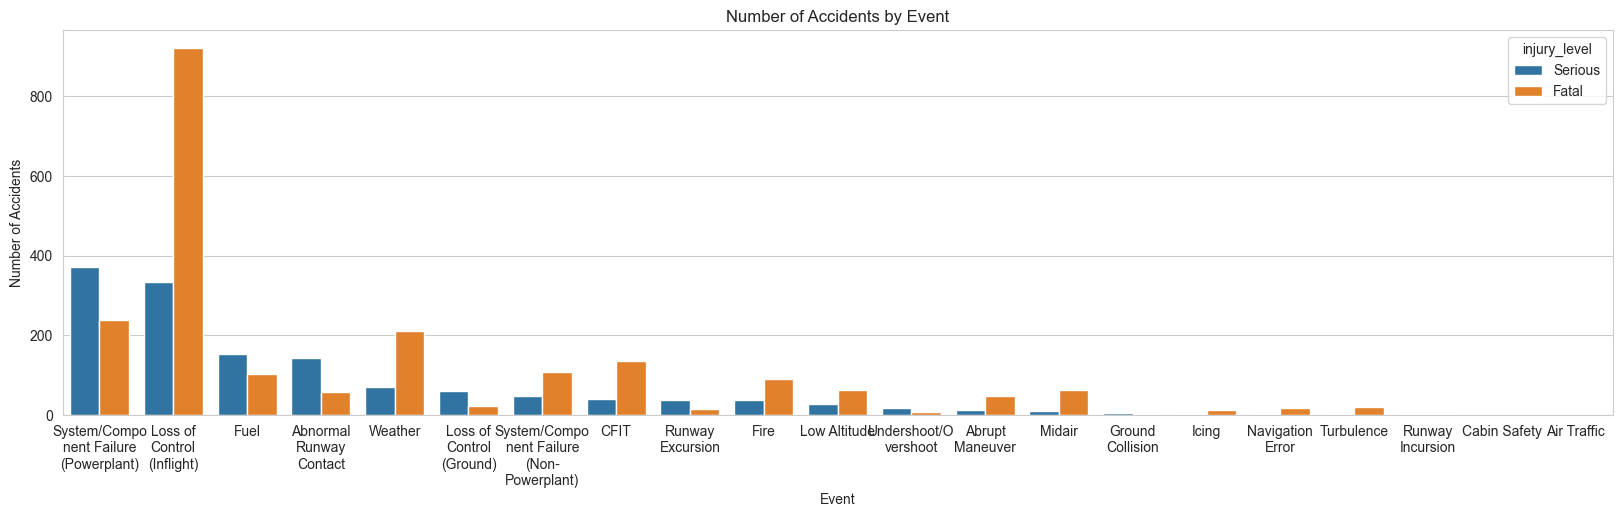

In [17]:
# Create a bar plot of the phases of 'df_events_grouped'
# Use the 'hue' argument to color the bars by 'injury_level'
plt.figure(figsize=(20, 5))
barplot = sns.barplot(x='event_cicttEventSOEGroup', y='count', hue='injury_level', data=df_events_grouped)

# Wrap the x-axis labels
barplot.set_xticklabels([textwrap.fill(label.get_text(), 12) for label in barplot.get_xticklabels()], rotation=0)

# Add title and labels to the plot
plt.title('Number of Accidents by Event')
plt.xlabel('Event')
plt.ylabel('Number of Accidents')

# Show the plot
plt.show()

In [18]:
df_events_grouped.to_json('data/accident_events.json', orient='records')

# Text Analysis of Probable Causes

The 'cm_probableCause' column is analyzed using advanced NLP techniques to identify common themes or keywords. This involves tokenizing the text, removing stop words, and lemmatizing the words.

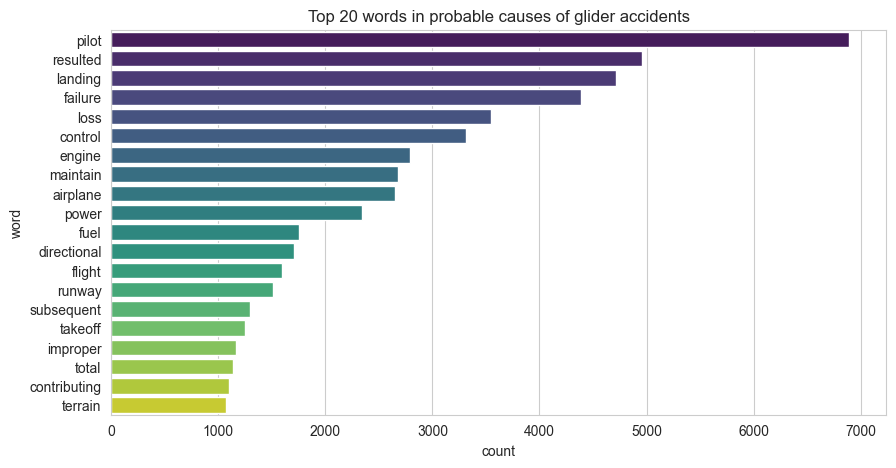

In [19]:
# Simple word count removing stop words
# Drop rows where 'cm_probableCause' is NaN
df_causes = df.dropna(subset=['cm_probableCause'])

# Initialize CountVectorizer
vec = CountVectorizer(stop_words='english')

# Fit and transform the 'cm_probableCause' column
X = vec.fit_transform(df_causes['cm_probableCause'])

# Sum up the counts of each word
word_counts = np.array(np.sum(X, axis=0)).reshape((-1,))
words = np.array(vec.get_feature_names_out())

# Create a DataFrame with the words and their counts
word_count_df = pd.DataFrame({'word': words, 'count': word_counts})

# Sort the DataFrame by 'count' in descending order and reset the index
word_count_df = word_count_df.sort_values('count', ascending=False).reset_index(drop=True)

# Display the top 20 words
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=word_count_df.loc[0:19, :], palette='viridis')
plt.title('Top 20 words in probable causes of glider accidents')
plt.show()

In [20]:
word_count_df.loc[0:19, :].to_json('data/accident_causes_word_count.json', orient='records')

## Topic Modeling

The analysis using Non-Negative Matrix Factorization (NMF) on the narrative descriptions of glider accidents has revealed five distinct topics, each characterized by a set of key words. These topics provide insights into different aspects and causes of the accidents:

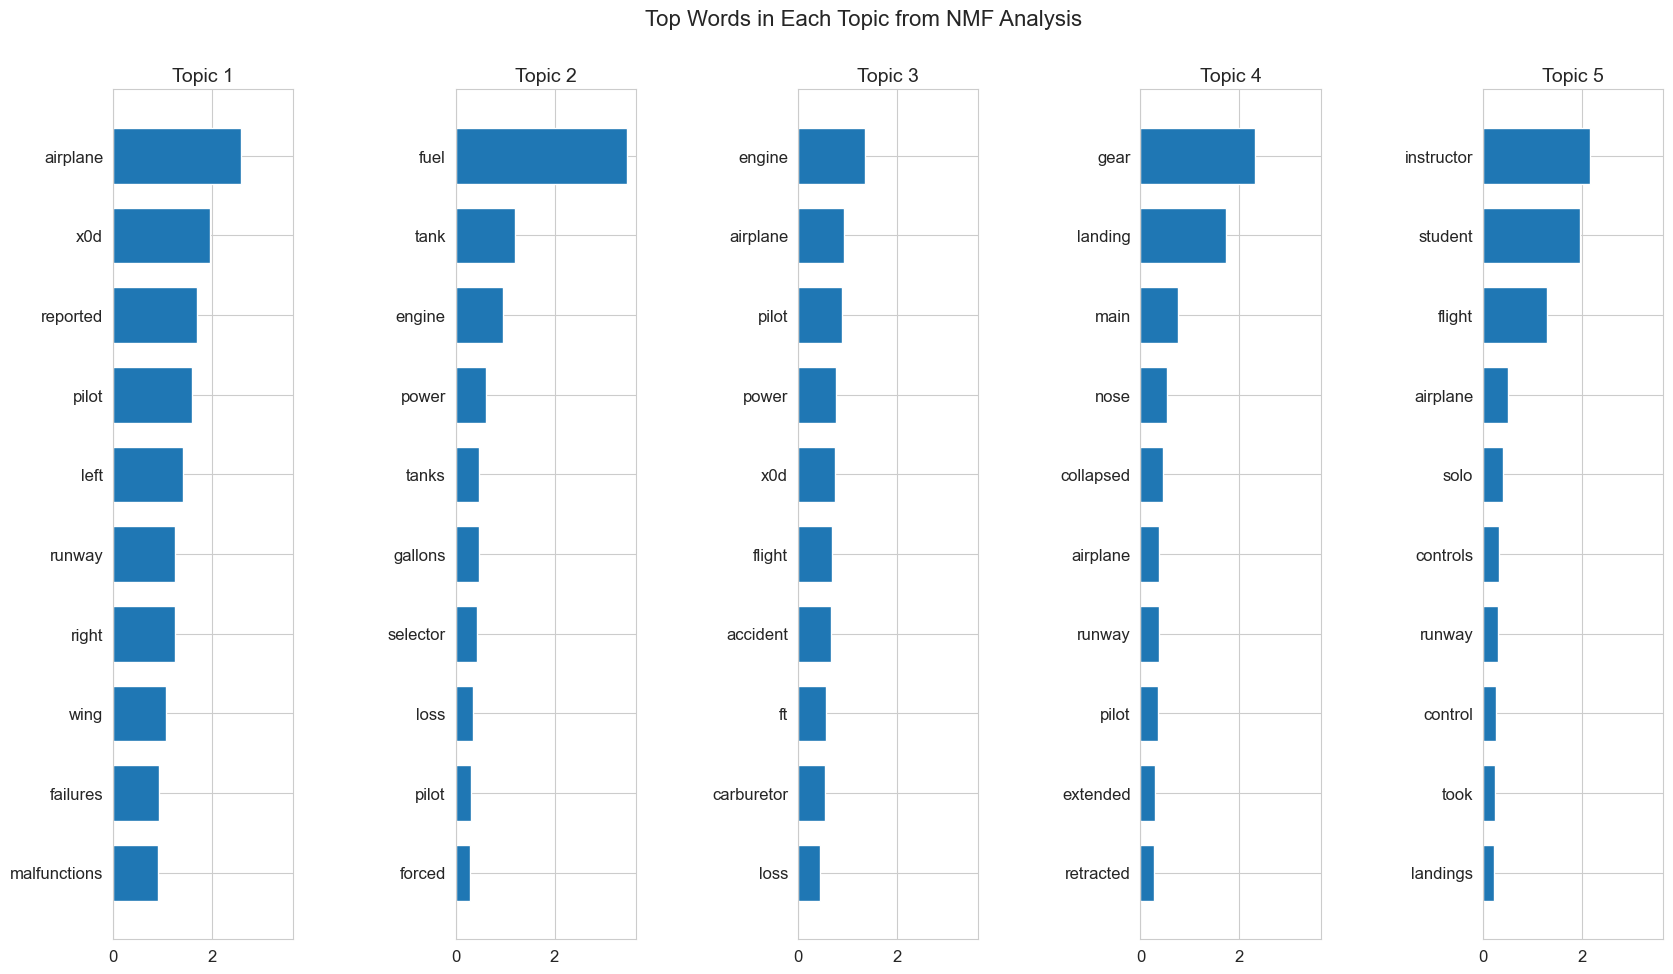

In [21]:
# Extracting the narrative descriptions
narratives = [case.get('analysisNarrative') for case in data if case.get('analysisNarrative')]

# Filtering out cases without a narrative
narratives = [narr for narr in narratives if narr]

# Vectorizing the narrative texts for NMF (Non-Negative Matrix Factorization)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(narratives)

# Applying NMF to extract topics
nmf = NMF(n_components=5, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# Getting the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Displaying the top words for each topic
num_top_words = 10
top_words = {f'Topic {i+1}': [feature_names[index] for index in H[i].argsort()[-num_top_words:][::-1]] for i in range(nmf.n_components)}

# Function to display top words for each topic in a bar plot
def display_top_words_for_topics(H, feature_names, n_top_words=10):
    fig, axes = plt.subplots(1, 5, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(H):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.suptitle('Top Words in Each Topic from NMF Analysis', fontsize=16)
    plt.show()

# Displaying the top words for each topic in a bar plot
display_top_words_for_topics(H, feature_names)

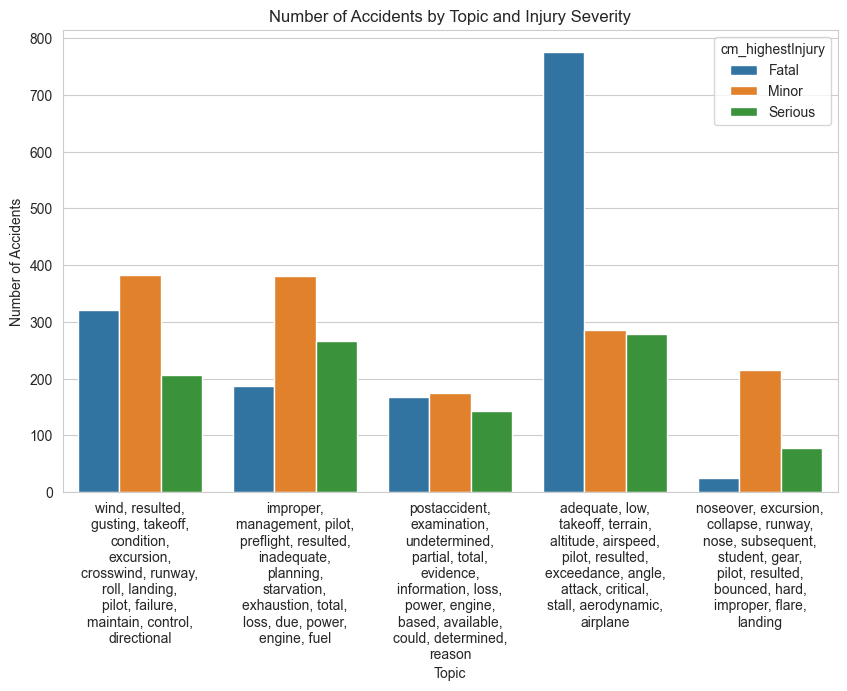

In [22]:
# Define function for text preprocessing
def preprocess_text(text):
    # Check if input is a string
    if not isinstance(text, str):
        return []
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return words

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocess the 'cm_probableCause' text
df['cm_probableCause_preprocessed'] = df['cm_probableCause'].apply(preprocess_text)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Join the words into a single string
df['cm_probableCause_preprocessed'] = df['cm_probableCause_preprocessed'].apply(' '.join)

# Now apply the vectorizer
tfidf_matrix = vectorizer.fit_transform(df['cm_probableCause_preprocessed'])

# Convert the matrix to a DataFrame for easier viewing
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Initialize NMF model with 5 components (topics)
nmf = NMF(n_components=5, random_state=42)

# Fit the model to the TF-IDF matrix
nmf.fit(tfidf_matrix)

# Add the topic assignments to the original DataFrame
df['topic'] = nmf.transform(tfidf_matrix).argmax(axis=1)

# Group data by topic and cm_highestInjury, and count the number of accidents in each group
topic_injury_counts = df.groupby(['topic', 'cm_highestInjury']).size().reset_index(name='counts')

# Filter accidents with no injuries
topic_injury_counts = topic_injury_counts[topic_injury_counts['cm_highestInjury'] != 'None']

# Create a bar plot of the accident counts with wrapped topic labels
plt.figure(figsize=(10, 6))
sns.barplot(x='topic', y='counts', hue='cm_highestInjury', data=topic_injury_counts)
plt.title('Number of Accidents by Topic and Injury Severity')
plt.xlabel('Topic')
plt.ylabel('Number of Accidents')

# Get the top 15 words for each topic
topic_words = []
for i, topic in enumerate(nmf.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]]
    topic_words.append(', '.join(top_words))

# Wrap the topic labels and rotate them 90 degrees
plt.xticks(range(5), ['\n'.join(wrap(label, 20)) for label in topic_words], rotation=0)
plt.show()

In [23]:
# Replace the topic numbers with topic labels
topic_injury_counts['topic'] = topic_injury_counts['topic'].replace({0: 'Airport and Landing', 1: 'Pilot Actions and Aircraft Conditions', 2: 'Tow Plane and Takeoff Operations', 3: 'Mechanical and Operational Failures', 4: 'Training and Flight Patterns'})

topic_injury_count_pivot = topic_injury_counts.pivot(index='topic', columns='cm_highestInjury', values='counts')
topic_injury_count_pivot.reset_index(inplace=True)

topic_injury_count_pivot.to_json('data/accident_topics.json', orient='records')


# Accidents Over Time

The number of accidents is plotted over time, broken down by injury severity. This shows the evolution of accidents and injury severity over time.

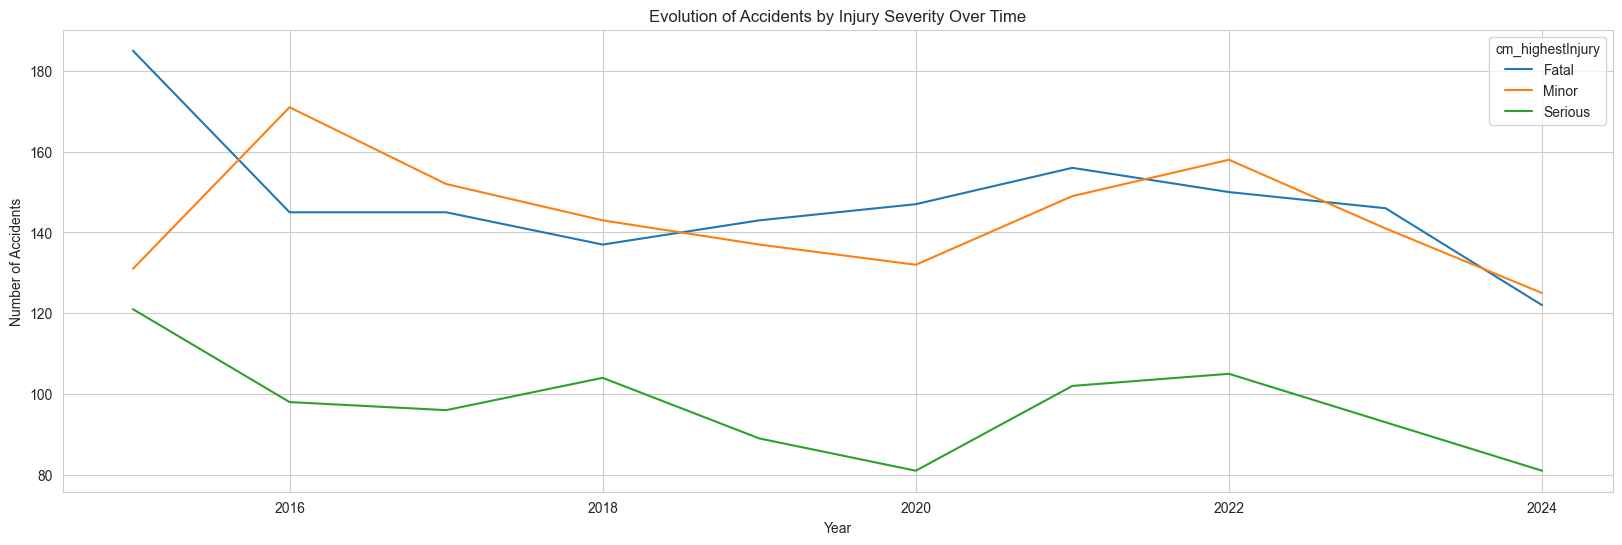

In [24]:
# Plot
# Convert 'cm_eventDate' to datetime format
df['cm_eventDate'] = pd.to_datetime(df['cm_eventDate'])

# Extract year from 'cm_eventDate'
df['year'] = df['cm_eventDate'].dt.year

# Count the number of accidents for each year and injury severity
year_injury_counts = df.groupby(['year', 'cm_highestInjury']).size().reset_index(name='counts')

# Filter accidents with no injuries
year_injury_counts = year_injury_counts[year_injury_counts['cm_highestInjury'] != 'None']

# Create a line plot of the accident counts over time
plt.figure(figsize=(20, 6))
sns.lineplot(x='year', y='counts', hue='cm_highestInjury', data=year_injury_counts)
plt.title('Evolution of Accidents by Injury Severity Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()

### Aviation Safety Improvement Recommendations

**1. Engine Power and Mechanical Failure Mitigation (Topic 1 & 4):**
- **Enhanced Engine Monitoring:** Implement more rigorous engine health monitoring systems to detect early signs of mechanical failure. Require regular in-depth diagnostics for critical components.
- **Mandatory Engine Overhaul Cycles:** Shorten overhaul cycles for engines identified as high-risk or those with recurring issues.
- **Pilot Training in Engine-Out Scenarios:** Expand pilot training to emphasize handling partial and total engine failures, including advanced simulators replicating real-world emergency situations.

**2. Stall and Aerodynamic Awareness (Topic 2):**
- **Stall Recovery Training:** Mandate periodic stall recovery training that emphasizes aerodynamic awareness, critical angle of attack management, and recovery techniques.
- **Advanced Stall Warning Systems:** Equip aircraft with enhanced stall prevention and warning systems that provide real-time feedback to pilots on approaching critical angles.
- **In-Flight Simulations:** Conduct regular in-flight simulations focusing on stall conditions at different flight phases, particularly during takeoff and landing.

**3. Landing and Control Issues (Topic 3):**
- **Landing Proficiency Programs:** Implement continuous landing proficiency programs, targeting proper flare, wind compensation techniques, and directional control.
- **Runway Excursion Prevention:** Adopt improved runway monitoring and surface condition reporting systems to assist pilots in decision-making during landing and rollout.
- **Crosswind Training:** Require enhanced crosswind landing certification to improve pilot skills in adverse weather conditions.

**4. Fuel Management and Flight Planning (Topic 4):**
- **Fuel Monitoring Technologies:** Integrate real-time fuel monitoring technologies to alert pilots of abnormal fuel consumption patterns.
- **Pre-Flight Fuel Planning:** Reinforce comprehensive fuel planning and contingency management during pre-flight checks, particularly for long-haul flights.
- **Emergency Diversion Protocols:** Review and reinforce emergency diversion protocols to ensure pilots are prepared for fuel-related emergencies.

**5. Terrain Clearance and Altitude Management (Topic 5):**
- **Terrain Awareness Systems:** Mandate terrain awareness and warning systems (TAWS) on all aircraft, regardless of size or type.
- **Altitude Management Training:** Expand altitude management training programs to prevent controlled flight into terrain (CFIT) incidents.
- **Minimum Safe Altitude Procedures:** Require stricter adherence to minimum safe altitude procedures, especially in mountainous or high-risk areas.

**General Recommendations:**
- **Safety Audits and Data Sharing:** Encourage data sharing across aviation organizations to identify recurring risks and collaboratively develop mitigation strategies.
- **Pilot Mental Health and Decision Making:** Introduce programs to support pilot mental health and enhance decision-making under stress.
- **Incident Reporting:** Foster a culture of non-punitive incident reporting to capture valuable data on near-misses and precursor events.

By implementing these targeted improvements, the aviation industry can work toward reducing the occurrence of severe accidents and enhancing overall flight safety for pilots, crew, and passengers.

